RSAM On The Fly
--

Calculate RSAM 'on the fly' for a single channel.

The RSAM interval is fixed at 10 mins, the most commonly used interval. 

The intention is that this notebook is used to quickly calculate RSAM data for a seismic stream of interest. All seismic waveform data are read into memory at once, so specifying too long a date range will make this overly slow. This notebook is therefore _not_ intended to be used to calculate RSAM values for long periods of time.

The RSAM data are simply plotted to check you have retrieved the data you want, and output as a CSV file that can be used for further analysis.

The CSV file format is

`,rsam
2018-05-08T00:00:00,18.452843689933633
2018-05-08T00:10:00,16.452106331639985
2018-05-08T00:20:00,16.536061488147663`

The date-time is ISO8601 format. The RSAM unit is nanometres/second. No attempt is made to limit the number of significant digits in the RSAM values

**This is not intended to be a siphisticated notebook, but a tool to fill a gap. No attempt has been made to set up nice input, or to hide code cells.**

In [1]:
import numpy as np
import obspy
from obspy.core import read, Trace, Stream, UTCDateTime
from obspy.clients.fdsn import Client
import datetime as dt
import pandas as pd

%matplotlib inline

**Edit this cell to specify stream, date range, and filters**

In [2]:
stream = 'MAVZ.10.HHZ.NZ'

#dates are inclusive, and complete days
date1 = '2018-05-08'
date2 = '2018-05-08'

#filter options are 'none', 'lp', 'hp', 'bp'

# filtertype = 'none'

filtertype = 'bp'
f1 = 1
f2 = 4

# filtertype = 'hp'
# f = 3

**Prepare dates and stream information**

In [3]:
d1 = dt.datetime.strptime(date1, '%Y-%m-%d')
d2 = dt.datetime.strptime(date2, '%Y-%m-%d')

site, loc, cmp, net = str.split(stream, '.')

**GeoNet's FDSN web servers**

In [4]:
arc_client = 'http://service.geonet.org.nz'
nrt_client = 'http://beta-service-nrt.geonet.org.nz'

**Retrieve seismic time series**

In [5]:
start = UTCDateTime(d1)
end = UTCDateTime(d2) + 86400
try:
    c = Client(base_url=nrt_client)
    st = c.get_waveforms(net,site,loc,cmp,start,end,attach_response=True)
except:
    try:
        c = Client(base_url=arc_client)
        st = c.get_waveforms(net,site,loc,cmp,start,end,attach_response=True)
    except:
        print("No data found for %s\n"%('.'.join((net, site, loc, cmp))))

**Prepare seismic time series**

In [6]:
st.remove_sensitivity()
st.merge(fill_value = 'interpolate')    #in case stream has more than one trace
tr = st[0]

**Filter settings**

In [7]:
if filtertype == 'lp':
    tr.filter('lowpass', freq=f, corners=4, zerophase=False)
elif filtertype == 'hp':
    tr.filter('highpass', freq=f, corners=4, zerophase=False)
elif filtertype == 'bp':
    tr.filter('bandpass', freqmin=f1, freqmax=f2, corners=4, zerophase=False)

**RSAM calculation, values put into a Pandas dataframe**

In [8]:
#initialise dataframe
rsam = pd.DataFrame()

t = tr.stats.starttime
index = 0
#loop through data in 600sec (10 min) blocks
while t < tr.stats.endtime:
    tr10m = tr.slice(t, t + 600)
    duration = tr10m.stats.npts * tr10m.stats.delta
    if duration >= 500:
        if duration < 600:
            tr10m = tr.slice(tr.stats.endtime - 600, tr.stats.endtime) 
        #detrend and filter
        #tr10m.detrend(type='constant')
    
        absolute = np.absolute(tr10m.data) #absolute value
        tr10m.data = absolute #assign back to trace
        mean = tr10m.data.mean()
        mean = mean / 1e-9 #convert to nanometres so dealing with whole numbers
        data = {'datetime':t, 'rsam':mean}
        data = {'rsam':mean}
        tstr = pd.to_datetime(UTCDateTime.strftime(t, '%Y-%m-%dT%H:%M:%S'))
        df = pd.DataFrame(data, index=[tstr])
        rsam = rsam.append(df)
        index += 1
    t += 600

**Simple plot**

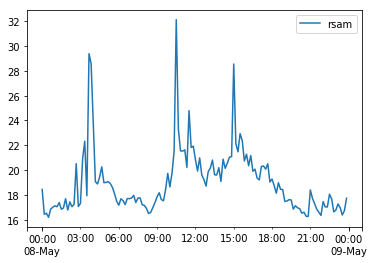

In [9]:
rs = rsam.plot()

**Output to CSV file**

In [14]:
#get rsam output file name
if filtertype == 'none':
    rsfile = 'rsam_'+stream+'_'+date1+'-'+date2+'.csv'
elif (filtertype == 'lp') | (filtertype == 'hp'):
    strf = '%.2f' %f
    rsfile = 'rsam_'+stream+'_'+date1+'-'+date2+'_'+filtertype+'_'+strf+'.csv'
elif filtertype == 'bp':
    strf1 = '%.2f' %f1
    strf2 = '%.2f' %f2
    rsfile = 'rsam_'+stream+'_'+date1+'-'+date2+'_'+filtertype+'_'+strf1+'-'+strf2+'.csv'

rsam.to_csv(rsfile, date_format='%Y-%m-%dT%H:%M:%S')